# LSGAN

- paper : https://arxiv.org/abs/1611.04076
- implementation
    - torch : 
    - tf : https://github.com/xudonmao/LSGAN

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.datasets import LSUN

from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [2]:
data_dir = "data/lsun"
save_dir = "result/lsgan"
img_classes = ["bedroom_train"]
workers = 2
epochs = 20
batch_size = 256
image_size = 112
nc = 3
nz = 1024
ngf = 64
ndf = 64
lr = 0.001
beta1 = 0.5
image_list_freq = 500
device = "cuda:0"
indent = "    "

## Dataset

In [3]:
dataset = LSUN(
    root=data_dir,
    classes=img_classes,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

### Image preview

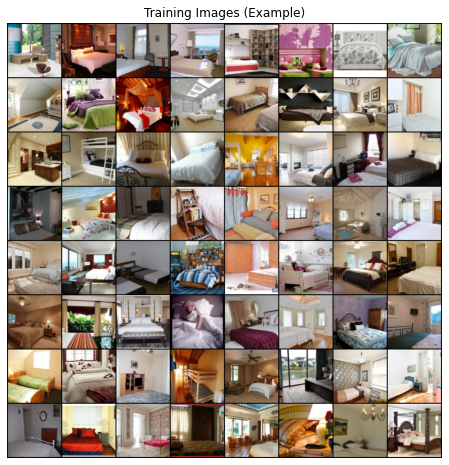

In [4]:
batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images (Example)")
plt.imshow(np.transpose(make_grid(batch[0][:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

## Models : Generator, Discriminator

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.block1 = self._first_block(
            in_features=nz,
            out_features=(ngf*4)*(image_size//16)*(image_size//16)
        )
        self.block2_1 = self._block(
            in_channels=(ngf*4),
            out_channels=(ngf*4),
            kernel_size=3,
            stride=2,
            padding=1
        )
        self.block2_2 = self._block(
            in_channels=(ngf*4),
            out_channels=(ngf*4),
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.block3_1 = self._block(
            in_channels=(ngf*4),
            out_channels=(ngf*4),
            kernel_size=3,
            stride=2,
            padding=1
        )
        self.block3_2 = self._block(
            in_channels=(ngf*4),
            out_channels=(ngf*4),
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.block4 = self._block(
            in_channels=(ngf*4),
            out_channels=(ngf*2),
            kernel_size=3,
            stride=2,
            padding=1
        )
        self.block5 = self._block(
            in_channels=(ngf*2),
            out_channels=ngf,
            kernel_size=3,
            stride=2,
            padding=1
        )
        self.block6 = self._last_block(
            in_channels=ngf,
            out_channels=nc,
            kernel_size=3,
            stride=1,
            padding=1
        )

    def _first_block(self, in_features, out_features, bias=True):
        return nn.Sequential(
            nn.Linear(
                in_features=in_features,
                out_features=out_features,
                bias=bias,
            ),
            nn.BatchNorm1d(
                num_features=out_features
            ),
            nn.ReLU(
                inplace=True
            )
        )
    
    def _block(self, in_channels, out_channels, kernel_size, stride, padding, bias=True):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                output_padding=(stride + 2 * padding - kernel_size),
                bias=bias
            ),
            nn.BatchNorm2d(
                num_features=out_channels
            ),
            nn.ReLU(
                inplace=True
            )
        )
    
    def _last_block(self, in_channels, out_channels, kernel_size, stride, padding, bias=True):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                output_padding=(stride + 2 * padding - kernel_size),
                bias=bias
            ),
            nn.Tanh()
        )
    
    def forward(self, x):
        # x : [batch, channel, h, w] = [batch, nz=1024, 1, 1]
        out = x.view(batch_size, -1)
        # out : [batch, channel * h * w] = [batch, nz=1024]
        
        out = self.block1(out).view(batch_size, ngf * 4, image_size // 16, image_size // 16)
        # out : [batch, channel, h, w] = [batch, ngf*4=256, image_size/16=7, image_size/16=7]
        
        out = self.block2_1(out)
        # out : [batch, channel, h, w] = [batch, ngf*4=256, image_size/8=14, image_size/8=14]
        
        out = self.block2_2(out)
        # out : [batch, channel, h, w] = [batch, ngf*4=256, image_size/8=14, image_size/8=14]
        
        out = self.block3_1(out)
        # out : [batch, channel, h, w] = [batch, ngf*4=256, image_size/4=28, image_size/4=28]
        
        out = self.block3_2(out)
        # out : [batch, channel, h, w] = [batch, ngf*4=256, image_size/4=28, image_size/4=28]
        
        out = self.block4(out)
        # out : [batch, channel, h, w] = [batch, ngf*2=128, image_size/2=56, image_size/2=56]
        
        out = self.block5(out)
        # out : [batch, channel, h, w] = [batch, ngf=64, image_size=112, image_size=112]
        
        out = self.block6(out)
        # out : [batch, channel, h, w] = [batch, nc=3, image_size=112, image_size=112]
        return out

In [23]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.block1 = self._first_block(
            in_channels=nc,
            out_channels=ndf,
            kernel_size=5,
            stride=2,
            padding=2
        )
        self.block2 = self._block(
            in_channels=ndf,
            out_channels=ndf * 2,
            kernel_size=5,
            stride=2,
            padding=2
        )
        self.block3 = self._block(
            in_channels=ndf * 2,
            out_channels=ndf * 4,
            kernel_size=5,
            stride=2,
            padding=2
        )
        self.block4 = self._block(
            in_channels=ndf * 4,
            out_channels=ndf * 8,
            kernel_size=5,
            stride=2,
            padding=2
        )
        self.block5 = self._last_block(
            in_features=((ndf * 8) * (image_size // 16) * (image_size // 16)),
            out_features=1
        )
        
    def _first_block(self, in_channels, out_channels, kernel_size, stride, padding, bias=True):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=bias                
            ),
            nn.LeakyReLU(
                negative_slope=0.2,
                inplace=True
            )
        )
    
    def _block(self, in_channels, out_channels, kernel_size, stride, padding, bias=True):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=bias                
            ),
            nn.BatchNorm2d(
                num_features=out_channels
            ),
            nn.LeakyReLU(
                negative_slope=0.2,
                inplace=True
            )
        )
    
    def _last_block(self, in_features, out_features, bias=True):
        return nn.Sequential(
            nn.Linear(
                in_features=in_features,
                out_features=out_features,
                bias=bias
            ),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # x : [batch, channel, h, w] = [batch, nc=3, image_size=112, image_size=112]
        out = self.block1(x)
        # out : [batch, channel, h, w] = [batch, ndf=64, image_size/2=56, image_size/2=56]
        
        out = self.block2(out)
        # out : [batch, channel, h, w] = [batch, ndf*2=128, image_size/4=28, image_size/4=28]
        
        out = self.block3(out)
        # out : [batch, channel, h, w] = [batch, ndf*4=256, image_size/8=14, image_size/8=14]
        
        out = self.block4(out)
        # out : [batch, channel, h, w] = [batch, ndf*8=512, image_size/16=7, image_size/16=7]
        
        out = self.block5(out.view(batch_size, -1)).view(batch_size, 1, 1, 1)
        # out : [batch, channel, h, w] = [batch, 1, 1, 1]
        return out

## Training

In [26]:
def init_weights(module):
    classname = module.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(module.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(module.weight.data, 1.0, 0.02)
        nn.init.constant_(module.bias.data, 0)

In [27]:
netG = Generator().to(device)
netG.apply(init_weights)
print(netG)

netD = Discriminator().to(device)
netD.apply(init_weights)
print(netD)

Generator(
  (block1): Sequential(
    (0): Linear(in_features=1024, out_features=12544, bias=True)
    (1): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block2_1): Sequential(
    (0): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block2_2): Sequential(
    (0): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block3_1): Sequential(
    (0): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=Tr

In [9]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1).to(device)

REAL_LABEL = 1
FAKE_LABEL = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))